<a href="https://colab.research.google.com/github/Mustaphaf15/Pyshop/blob/main/pipeline_projet_openclassroom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalation des packages

In [ ]:
!pip install shap
!pip install mlflow
!pip install lightgbm
!pip install imblearn
!pip install pynvml
!pip install pyngrok
!pip install dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 17.

### Charger les modules

In [ ]:
import os
import sys
import tempfile
import time
from datetime import datetime
from functools import partial
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import mlflow.shap
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, RandomOverSampler, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from mlflow.models.signature import infer_signature
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix,
                             f1_score,
                             make_scorer,
                             recall_score,
                             roc_auc_score,
                             roc_curve,
                             auc)
from sklearn.model_selection import (GridSearchCV,
                                     StratifiedKFold,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from logging import warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Connexion à google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Charger les précédents entrainement

In [ ]:
%cd /content
%mkdir mlruns
%mkdir artifacte
!cp -r /content/drive/MyDrive/experiments/mlruns /content/mlruns
!cp -r /content/drive/MyDrive/experiments/artifacts /content/artifacts


/content
cp: cannot stat '/content/drive/MyDrive/experiments/mlruns': No such file or directory
cp: cannot stat '/content/drive/MyDrive/experiments/artifacts': No such file or directory


### Charger les fonctions de préprocessing

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/input/application_train.csv')

In [ ]:
def create_new_features(df):
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    return df

In [ ]:
def get_clean_data_train(train_data):
    train_data = train_data.drop(columns=['SK_ID_CURR'], axis=1)
    train_data = train_data[(train_data['CODE_GENDER'] != 'XNA') & (train_data['NAME_INCOME_TYPE'] != 'Maternity leave') & (train_data['NAME_FAMILY_STATUS'] != 'Unknown')]
    train_data.loc[:,'DAYS_EMPLOYED'] = train_data['DAYS_EMPLOYED'].where(train_data['DAYS_EMPLOYED'] <= 0, np.nan)
    train_data = create_new_features(train_data)
    var_num = train_data.drop(columns=['TARGET']).select_dtypes(exclude=['object']).columns.tolist()
    var_cat = train_data.drop(columns=['TARGET']).select_dtypes(include=['object']).columns.tolist()
    return train_data, var_num, var_cat

In [ ]:
def business_scorer(y_true, y_pred):
    '''
    Scorer personnalisé pour calculer le coût métier avec un seuil donné.)
    '''
    TP_coeff = 0       # Vrais positifs
    FP_coeff = 0       # Faux positifs (prédit comme faisant défaut (1) mais ne fait pas défaut (0))
    FN_coeff = -10     # Faux négatifs (prédit comme ne faisant pas défaut (0) mais font défaut (1))
    TN_coeff = 1       # Vrais négatifs

    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()

    business_scor = (TP*TP_coeff + TN*TN_coeff + FP*FP_coeff + FN*FN_coeff)/(TN+FP+FN+TP)

    return business_scor

In [ ]:
# Créer le répertoire pour les artefacts
metrics_dir = "artifacts/metrics"
os.makedirs(metrics_dir, exist_ok=True)

def log_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['True Neg', 'True Pos'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Log the confusion matrix as an artifact
    cm_path = os.path.join(metrics_dir, "confusion_matrix.png")
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.show()
    plt.close()


def log_roc_curve(y_true, y_pred_prob):
    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Log ROC curve as an artifact
    roc_curve_path = os.path.join(metrics_dir, "roc_curve.png")
    plt.savefig(roc_curve_path)
    mlflow.log_artifact(roc_curve_path)
    plt.show()
    plt.close()


def log_business_score_vs_threshold(y_true, y_pred_prob):
    # Generate a range of thresholds
    thresholds = np.linspace(0, 1, 100)
    business_scores = [business_scorer(y_true, (y_pred_prob > t).astype(int)) for t in thresholds]

    # Plot Business Score vs Threshold
    plt.figure(figsize=(6, 5))
    plt.plot(thresholds, business_scores, color='green', lw=2)
    plt.title("Business Score vs Threshold")
    plt.xlabel('Threshold')
    plt.ylabel('Business Score')
    plt.grid(True)

    # Log the plot as an artifact
    business_score_path = os.path.join(metrics_dir, "business_score_vs_threshold.png")
    plt.savefig(business_score_path)
    mlflow.log_artifact(business_score_path)
    plt.show()
    plt.close()


def log_feature_importance(model, feature_names):
    # Get feature importance
    importance = model.feature_importances_

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    })
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    feature_importance_df = feature_importance_df.head(20)
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance')

    # Log the plot as an artifact
    feature_importance_path = os.path.join(metrics_dir, "feature_importance.png")
    plt.savefig(feature_importance_path)
    mlflow.log_artifact(feature_importance_path)
    plt.show()
    plt.close()

### Creation du pipeline et fonction d'entrainement

In [ ]:

def get_transformed_feature_names(pipeline, input_feature_names):
    """
    Retourne la liste des features après transformations dans le pipeline.

    Args:
    - pipeline : sklearn.pipeline.Pipeline ou imblearn.pipeline.Pipeline
    - input_feature_names : Liste des noms des colonnes originales.

    Returns:
    - Liste des noms des features transformées.
    """
    # Identifier le transformateur principal (ColumnTransformer)
    column_transformer = None
    for step_name, step in pipeline.named_steps.items():
        if isinstance(step, ColumnTransformer):
            column_transformer = step
            break

    if column_transformer is None:
        raise ValueError("Aucun ColumnTransformer trouvé dans le pipeline.")

    transformed_feature_names = []

    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'drop':
            continue

        if transformer == 'passthrough':
            # Ajout des colonnes inchangées
            transformed_feature_names.extend(np.array(input_feature_names)[columns].tolist())
        else:
            if hasattr(transformer, 'get_feature_names_out'):
                # Obtenir les noms des features transformées
                if isinstance(columns, list):
                    feature_names = transformer.get_feature_names_out(columns)
                else:
                    feature_names = transformer.get_feature_names_out()

                transformed_feature_names.extend(feature_names)
            else:
                # Si le transformateur ne fournit pas de noms, utiliser les colonnes originales
                if isinstance(columns, list):
                    transformed_feature_names.extend(columns)
                else:
                    transformed_feature_names.append(columns)

    return transformed_feature_names

In [ ]:
def build_pipeline(model, var_num, var_cat, sampling_methods=None):
    # Preprocessing for numerical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, var_num),
            ('cat', categorical_transformer, var_cat)
        ])

    # Choose pipeline type based on SMOTE
    if sampling_methods:
        pipeline = make_imb_pipeline(
            preprocessor,
            sampling_methods,
            model
        )
    else:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    return pipeline

In [ ]:
def build_pipeline_gridsearchcv(model, param_grid, var_num, var_cat, custom_scorer=None, cv=5, sampling_methods=None):
    """
    Construit un pipeline avec un modèle et un wrapper GridSearchCV.

    Args:
    - model: Le modèle de base (ex. LGBMClassifier, RandomForestClassifier).
    - param_grid: Dictionnaire des paramètres pour GridSearchCV.
    - var_num: Liste des noms des variables numériques.
    - var_cat: Liste des noms des variables catégoriques.
    - custom_scorer: Fonction de scoring personnalisée pour GridSearchCV (par défaut=None).
    - cv: Nombre de plis pour la validation croisée (par défaut=5).

    Returns:
    - Un pipeline enveloppé avec GridSearchCV ou un simple pipeline si aucun param_grid n'est fourni.
    """
    pipeline = build_pipeline(model, var_num, var_cat, sampling_methods=sampling_methods)
    business_scorer = make_scorer(custom_scorer, greater_is_better=False)

    # Si un param_grid est fourni, envelopper le pipeline avec GridSearchCV
    if param_grid:
        if custom_scorer:
            grid = GridSearchCV(
                estimator=pipeline,       # Pipeline de base
                param_grid=param_grid,    # Grille des hyperparamètres
                scoring=custom_scorer,  # Scorer personnalisé
                cv=cv,                    # Validation croisée
                n_jobs=-1                 # Utilisation de tous les cœurs disponibles
            )
        else:
            grid = GridSearchCV(
                estimator=pipeline,       # Pipeline de base
                param_grid=param_grid,    # Grille des hyperparamètres
                scoring='roc_auc',        # Scorer par défaut : AUC
                cv=cv,                    # Validation croisée
                n_jobs=-1                 # Utilisation de tous les cœurs disponibles
            )
        return grid
    else:
        return pipeline
    # Retourner le pipeline simple si aucun param_grid n'est fourni
    return pipeline


In [ ]:
def train_and_log_model(pipeline, train_data, name_experiment):
    # Split the data (60% train, 20% test, 20% validation)
    X = train_data.drop('TARGET', axis=1)
    y = train_data['TARGET']
    mlflow.set_experiment(name_experiment)
    input_example = train_data.drop(columns=['TARGET']).dropna(how='all').iloc[:5].copy()
    output_example = train_data.dropna(how='all').loc[:5, 'TARGET'].copy()
    model_signature = infer_signature(input_example, output_example)

    # Split into train and test sets (60% train, 40% remaining for validation and test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

    # Further split the remaining data into test and validation sets (50% test, 50% validation)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Access the model based on pipeline structure
    if isinstance(pipeline, GridSearchCV):
        # Extract the model inside the pipeline from GridSearchCV
        model_name = pipeline.estimator.steps[-1][1].__class__.__name__

    else:
        # Directly extract the model name from the pipeline
        model_name = pipeline[-1].__class__.__name__

    # Enable autologging
    if model_name == 'LGBMClassifier':
        mlflow.lightgbm.autolog(log_input_examples=True, silent=True)
    elif model_name == 'XGBClassifier':
        mlflow.xgboost.autolog(log_input_examples=True, silent=True)
    else:
        mlflow.autolog(log_input_examples=True, silent=True)

    # Train the model
    current_time = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
    with mlflow.start_run(run_name=f'{model_name}_{current_time}', log_system_metrics=True):
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        end_time = time.time()
        if isinstance(pipeline, GridSearchCV):
            print(f"Best model parameters: {pipeline.best_params_}")
            pipeline = pipeline.best_estimator_
            model = pipeline.steps[-1][1]
        else:
            model = pipeline[-1]
            print(f"Model parameters: {pipeline.get_params}")

        # Log metrics on the validation set
        y_pred = pipeline.predict(X_val)
        y_pred_prob = pipeline.predict_proba(X_val)[:, 1]

        # Calculate metrics
        fit_time = end_time - start_time
        auc = roc_auc_score(y_val, y_pred_prob)
        f1 = f1_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        thresholds = np.linspace(0, 1, 100)
        costs = [business_scorer(y_test, (y_pred_prob > t).astype(int)) for t in thresholds]
        optimal_threshold = thresholds[np.argmin(costs)]

        # Log metrics
        mlflow.log_metric("Fit_time", fit_time)
        print("Fit_time", fit_time)
        mlflow.log_metric("AUC", auc)
        print("AUC", auc)
        mlflow.log_metric("F1_score", f1)
        print("F1_score", f1)
        mlflow.log_metric("Recall", recall)
        print("Recall", recall)
        #mlflow.log_metric("Business_Score", business_score)
        #print("Business_Score", business_score)
        mlflow.log_metric("optimal_threshold", optimal_threshold)
        print("optimal_threshold", optimal_threshold)

        #log_business_score_vs_threshold(y_val, y_pred_prob, scorer=business_scorer)
        # Log artifacts
        log_confusion_matrix(y_val, y_pred)
        log_roc_curve(y_val, y_pred_prob)

        # Log feature importance for specific models
        if model_name == 'LGBMClassifier':
            # Récupérer les noms des colonnes transformées
            transformed_feature_names = get_transformed_feature_names(pipeline, X_train.columns)
            log_feature_importance(model, transformed_feature_names)

        # log log_business_score_vs_threshold
        log_business_score_vs_threshold(y_val, y_pred_prob)

        # Log the model
        if model_name == 'LGBMClassifier':
            mlflow.lightgbm.log_model(
                sk_model=pipeline,
                signature=model_signature,
                artifact_path=model_name.lower() + "_model"
            )
        elif model_name == 'XGBClassifier':
            mlflow.xgboost.log_model(
                sk_model=pipeline,
                signature=model_signature,
                artifact_path=model_name.lower() + "_model"
            )
        else:
            mlflow.sklearn.log_model(
                sk_model=pipeline,
                signature=model_signature,
                artifact_path=model_name.lower() + "_model"
            )

### Charger les données

In [ ]:
train_data, var_num, var_cat = get_clean_data_train(train_data)

# Définitions des modèles de classification

## 1. LGBMClassifier
Modèle basé sur les **arbres de décision en gradient boosting**, optimisé pour la vitesse et l'efficacité, adapté aux grandes bases de données.

## 2. RandomForestClassifier
Ensemble d'arbres de décision entraînés sur des sous-échantillons aléatoires des données, avec moyennage pour améliorer la précision et réduire le surapprentissage.

## 3. KNeighborsClassifier
Méthode des k-plus proches voisins (**k-NN**) qui classe un point en fonction de la majorité des étiquettes de ses k voisins les plus proches.

## 4. GaussianProcessClassifier
Modèle probabiliste basé sur des **processus gaussiens**, qui offre des prévisions avec des mesures d'incertitude, adapté aux petites données.

## 5. DecisionTreeClassifier
Modèle qui divise les données en un ensemble de règles hiérarchiques sous forme d'arbre pour effectuer une classification.

## 6. AdaBoostClassifier
Algorithme d'ensemble qui améliore les prédictions en combinant plusieurs modèles faibles (souvent des arbres de décision) avec un système de pondération itératif.

## 7. GaussianNB
Classifieur bayésien naïf basé sur une hypothèse de distribution gaussienne des données dans chaque classe.

## 8. QuadraticDiscriminantAnalysis (QDA)
Modèle bayésien qui utilise une frontière quadratique pour séparer les classes, prenant en compte la variance de chaque classe.

## 9. GradientBoostingClassifier
Ensemble d'arbres de décision construits séquentiellement pour minimiser une fonction de perte, bien adapté aux données complexes.


### Création des grille

In [ ]:
param_grids = {
    KNeighborsClassifier: {
        'kneighborsclassifier__n_neighbors': [3, 5, 10],
        'kneighborsclassifier__weights': ['uniform', 'distance'],
        'kneighborsclassifier__metric': ['minkowski', 'euclidean']
    },
    XGBClassifier: {
        'xgbclassifier__n_estimators': [100, 200, 500],
        'xgbclassifier__learning_rate': [0.01, 0.1, 0.3],
        'xgbclassifier__max_depth': [3, 5, 7],
        'xgbclassifier__subsample': [0.8, 1.0],
        'xgbclassifier__colsample_bytree': [0.8, 1.0],
        'xgbclassifier__gamma': [0, 0.1, 0.5],
        'xgbclassifier__reg_alpha': [0, 0.1, 1],
        'xgbclassifier__reg_lambda': [0, 0.1, 1]
    },
    SVC: {
        'svc__C': [0.1, 1, 10],
        'svc__kernel': ['linear', 'rbf', 'poly'],
        'svc__gamma': ['scale', 'auto']
    },
    GaussianProcessClassifier: {
        'gaussianprocessclassifier__max_iter_predict': [50, 100, 200],
        'gaussianprocessclassifier__warm_start': [True, False]
    },
    DecisionTreeClassifier: {
        'decisiontreeclassifier__criterion': ['gini', 'entropy'],
        'decisiontreeclassifier__max_depth': [None, 10, 20, 50],
        'decisiontreeclassifier__min_samples_split': [2, 5, 10]
    },
    RandomForestClassifier: {
        'randomforestclassifier__n_estimators': [100, 200, 500],
        'randomforestclassifier__criterion': ['gini', 'entropy'],
        'randomforestclassifier__max_depth': [None, 10, 20, 50],
        'randomforestclassifier__min_samples_split': [2, 5, 10]
    },
    AdaBoostClassifier: {
        'adaboostclassifier__n_estimators': [50, 100, 200],
        'adaboostclassifier__learning_rate': [0.01, 0.1, 1, 10]
    },
    GaussianNB: {
        'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7]
    },
    QuadraticDiscriminantAnalysis: {
        'quadraticdiscriminantanalysis__reg_param': [0.0, 0.1, 0.5, 1.0],
        'quadraticdiscriminantanalysis__store_covariance': [True, False]
    },
    GradientBoostingClassifier: {
        'gradientboostingclassifier__n_estimators': [50, 100, 200],  # Nombre d'arbres
        'gradientboostingclassifier__learning_rate': [0.01, 0.1, 0.2],  # Taux d'apprentissage
        'gradientboostingclassifier__max_depth': [3, 5, 7],  # Profondeur maximale des arbres
        'gradientboostingclassifier__min_samples_split': [2, 5, 10],  # Nombre minimal d'échantillons requis pour diviser un nœud interne
        'gradientboostingclassifier__min_samples_leaf': [1, 2, 4],  # Nombre minimal d'échantillons requis pour être une feuille
        'gradientboostingclassifier__subsample': [0.6, 0.8, 1.0],  # Fraction d'échantillons utilisée pour former chaque arbre
        'gradientboostingclassifier__max_features': ['auto', 'sqrt', 'log2'],  # Nombre de caractéristiques à considérer pour trouver la meilleure séparation
    },
    LGBMClassifier: {
        'lgbmclassifier__num_leaves': [31, 63, 127],
        'lgbmclassifier__max_depth': [-1, 5, 10],
        'lgbmclassifier__learning_rate': [0.01, 0.1, 0.3],
        'lgbmclassifier__n_estimators': [100, 200, 500],
        'lgbmclassifier__subsample': [0.8, 1.0],
        'lgbmclassifier__colsample_bytree': [0.8, 1.0],
        'lgbmclassifier__reg_alpha': [0, 0.1, 1],
        'lgbmclassifier__reg_lambda': [0, 0.1, 1],
        'lgbmclassifier__force_row_wise' : [True]
    }
}

In [ ]:
classifiers = [
    LGBMClassifier,
    RandomForestClassifier,
    KNeighborsClassifier,
    GaussianProcessClassifier,
    DecisionTreeClassifier,
    AdaBoostClassifier,
    GaussianNB,
    QuadraticDiscriminantAnalysis,
    GradientBoostingClassifier,
]

### 1 *Entrainement de LGBMClassifier*

In [ ]:
pipeline = build_pipeline(
    model=LGBMClassifier(),
    var_num=var_num,
    var_cat=var_cat
)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'OWN_CAR_AGE...
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE',
                                                   'FONDKAPREMONT_MODE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE',
                                                   'EMERGENCYSTATE_MODE'])])),
                ('model', LGBMClassifier())])

2025/01/14 13:25:23 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/14 13:25:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


[LightGBM] [Info] Number of positive: 14793, number of negative: 169707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.781902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12518
[LightGBM] [Info] Number of data points in the train set: 184500, number of used features: 237
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080179 -> initscore=-2.439919
[LightGBM] [Info] Start training from score -2.439919
Model parameters: <bound method Pipeline.get_params of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                    

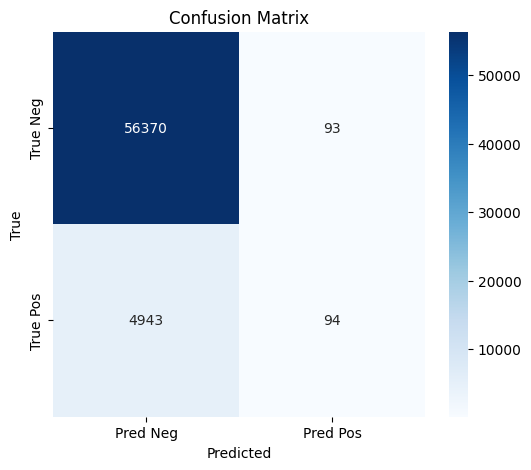

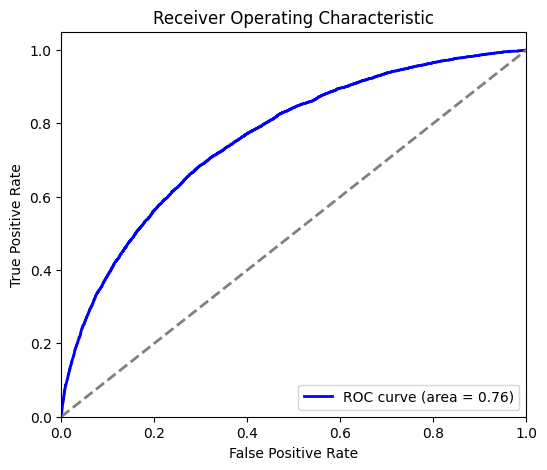

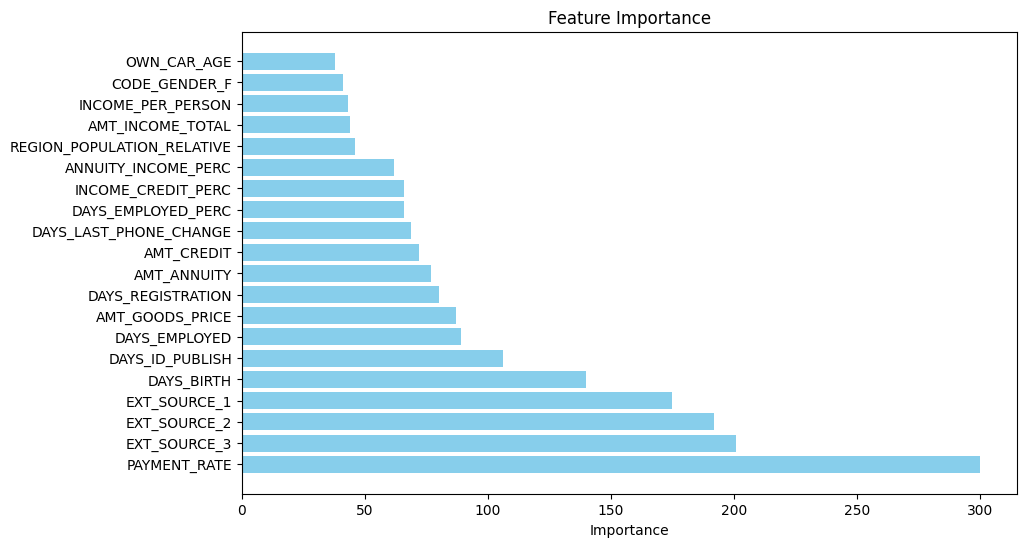

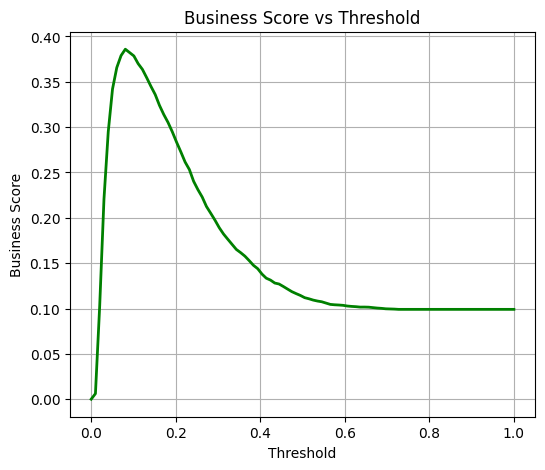

Successfully registered model 'lgbmclassifier_model'.
Created version '1' of model 'lgbmclassifier_model'.
2025/01/14 13:27:15 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/14 13:27:15 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [ ]:
train_and_log_model(pipeline, train_data, 'RandomForestClassifier')

Lors du précédent en trainement, on nous demande : Vous pouvez définir `force_row_wise=true` pour supprimer la surcharge.
Et si la mémoire n'est pas suffisante, vous pouvez définir `force_col_wise=true`.
Relancer en premier avec force_row_wise=true

2025/01/13 00:07:33 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/13 00:07:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


[LightGBM] [Info] Number of positive: 14793, number of negative: 169707
[LightGBM] [Info] Total Bins 12518
[LightGBM] [Info] Number of data points in the train set: 184500, number of used features: 237
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080179 -> initscore=-2.439919
[LightGBM] [Info] Start training from score -2.439919
Model parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'force_row_wise': True}
Fit_time 27.010828733444214
AUC 0.7592134482744204
F1_score 0.03598774885145482
Recall 0.018661901925749454
optimal_threshold 0.0


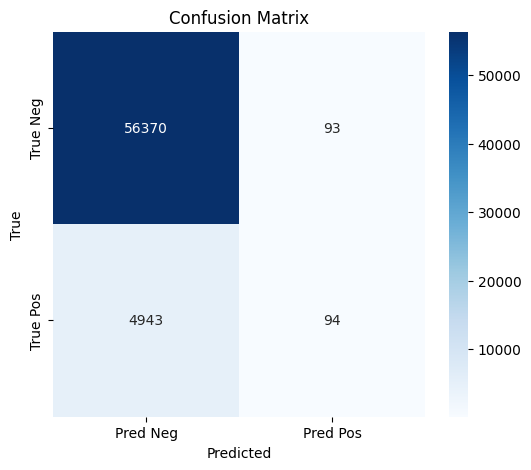

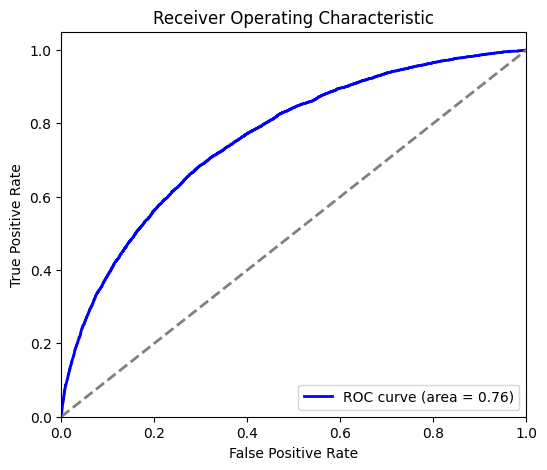

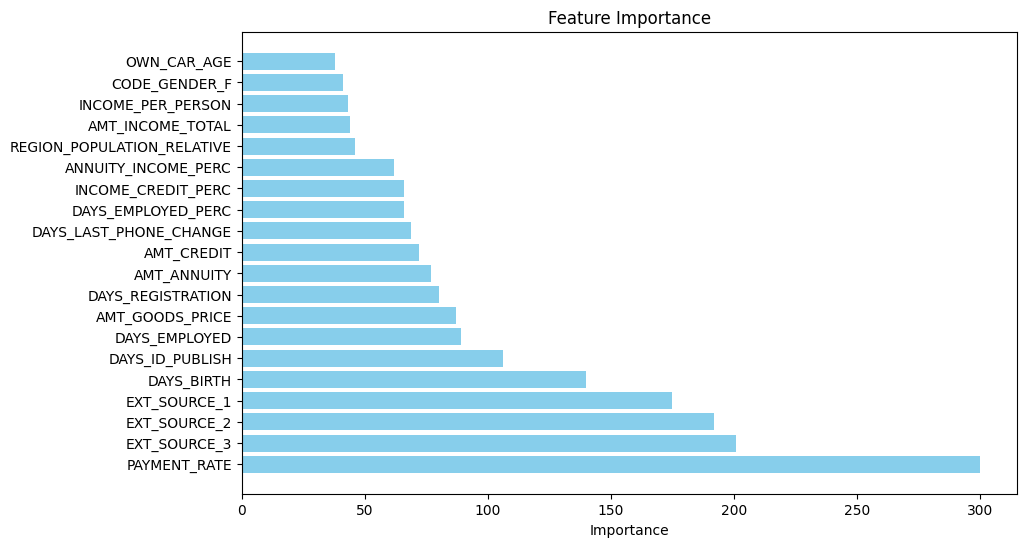

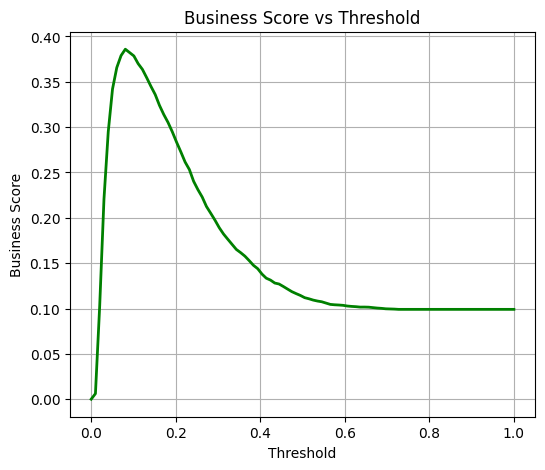

Registered model 'lgbmclassifier_model' already exists. Creating a new version of this model...
Created version '2' of model 'lgbmclassifier_model'.
2025/01/13 00:08:09 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/13 00:08:09 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [ ]:
pipeline = build_pipeline(
    model=LGBMClassifier(force_row_wise=True),
    var_num=var_num,
    var_cat=var_cat
)
train_and_log_model(pipeline, train_data, 'Default')

2025/01/13 00:08:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/13 00:08:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


[LightGBM] [Info] Number of positive: 14793, number of negative: 169707
[LightGBM] [Info] Total Bins 12518
[LightGBM] [Info] Number of data points in the train set: 184500, number of used features: 237
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080179 -> initscore=-2.439919
[LightGBM] [Info] Start training from score -2.439919
Model parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'force_col_wise': True}
Fit_time 29.62582802772522
AUC 0.7592134482744204
F1_score 0.03598774885145482
Recall 0.018661901925749454
optimal_threshold 0.0


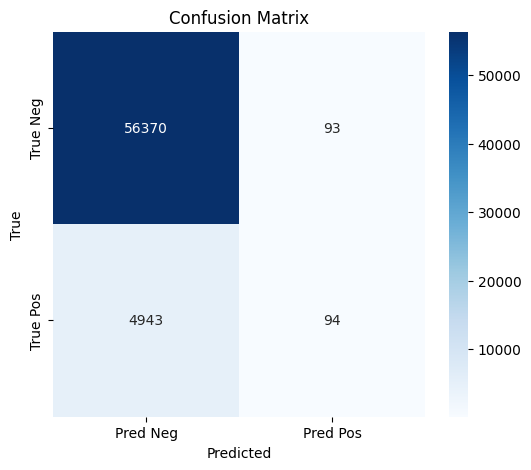

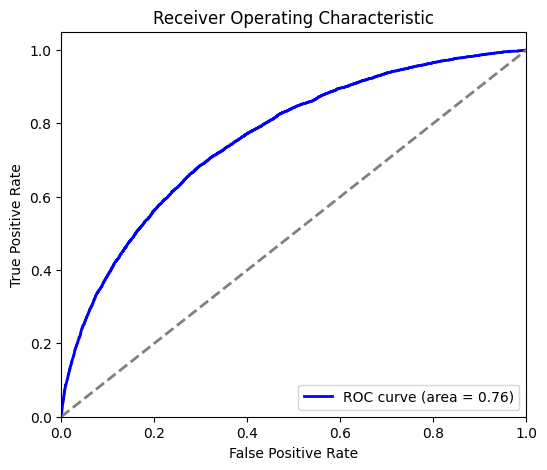

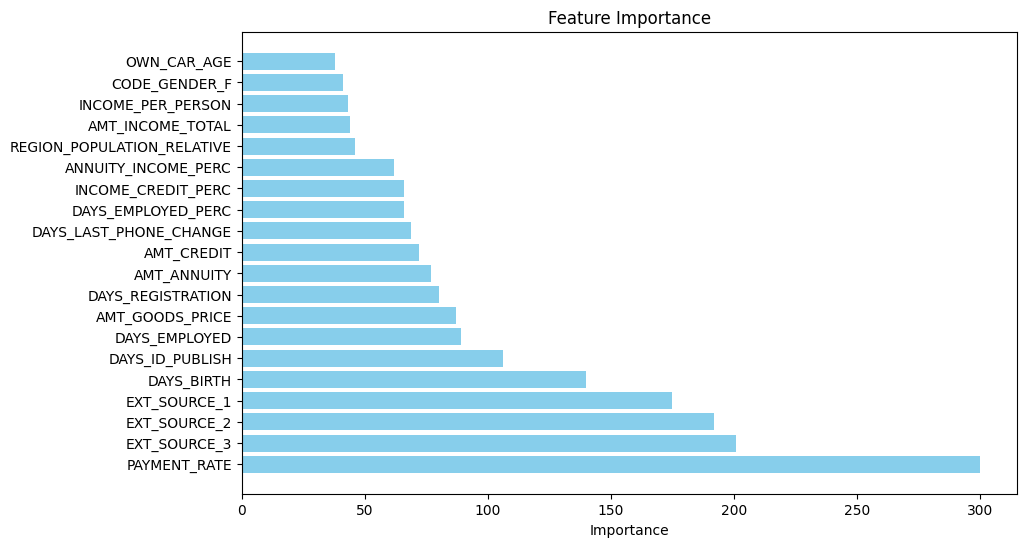

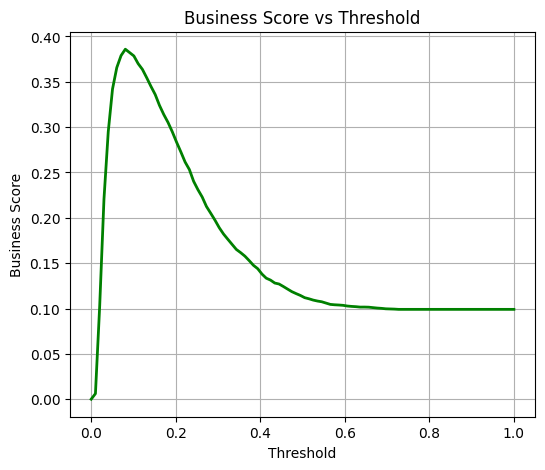

Registered model 'lgbmclassifier_model' already exists. Creating a new version of this model...
Created version '3' of model 'lgbmclassifier_model'.
2025/01/13 00:08:51 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/13 00:08:51 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [ ]:
pipeline = build_pipeline(
    model=LGBMClassifier(force_col_wise=True),
    var_num=var_num,
    var_cat=var_cat
)
train_and_log_model(pipeline, train_data, 'Default')

Tester les meilleurs hyperparmetres du [kernel kaggle](https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script)

2025/01/13 00:08:52 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/13 00:08:52 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Model parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.9497036, 'importance_type': 'split', 'learning_rate': 0.02, 'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 39.3259775, 'min_split_gain': 0.0222415, 'n_estimators': 10000, 'n_jobs': None, 'num_leaves': 34, 'objective': None, 'random_state': None, 'reg_alpha': 0.041545473, 'reg_lambda': 0.0735294, 'subsample': 0.8715623, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': 4, 'silent': -1, 'verbose': -1, 'force_row_wise': True}
Fit_time 583.5687885284424
AUC 0.7458293318531297
F1_score 0.08355746817285278
Recall 0.04625769307127258
optimal_threshold 0.0


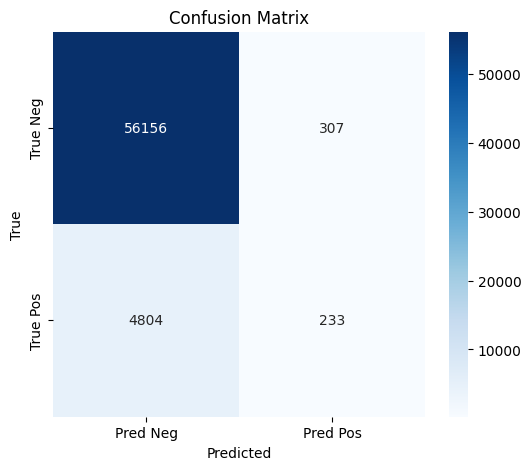

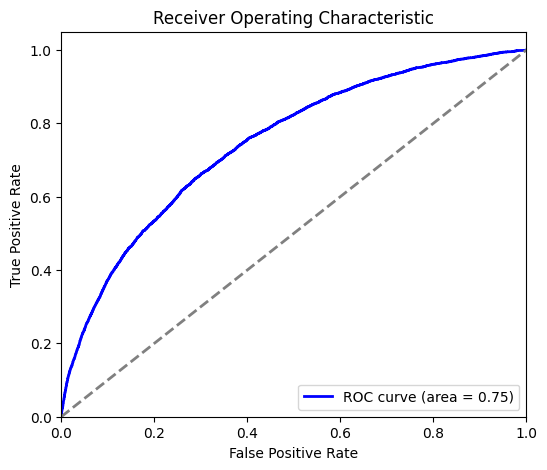

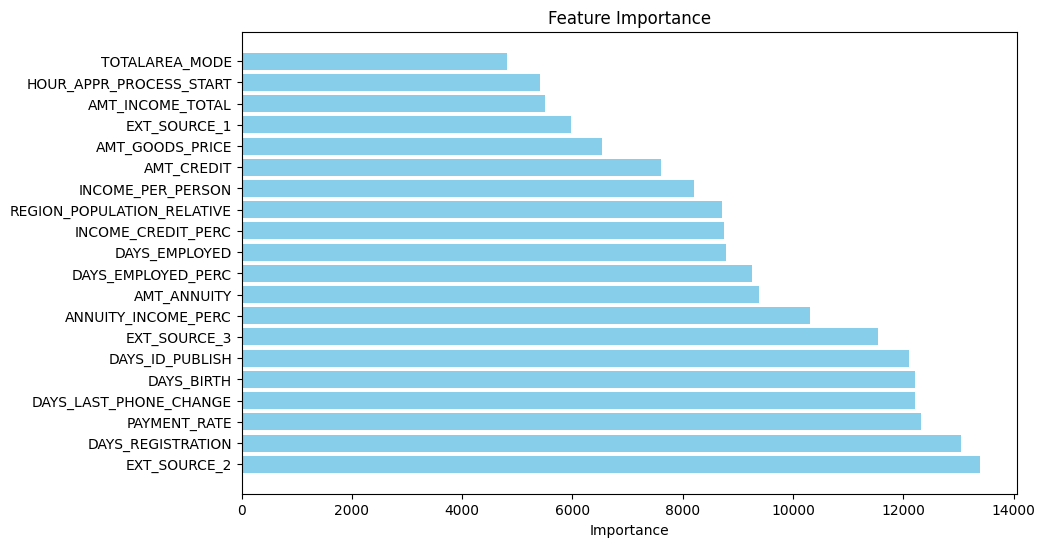

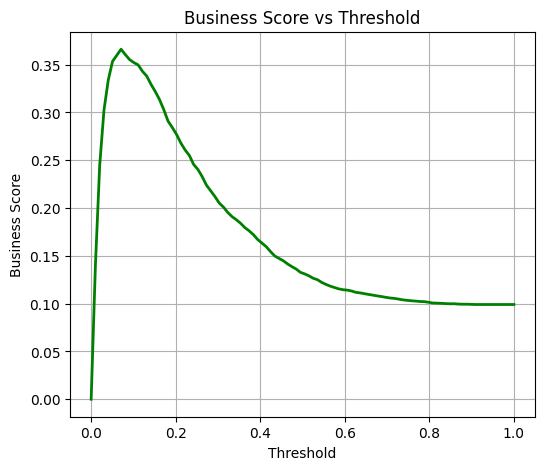

Registered model 'lgbmclassifier_model' already exists. Creating a new version of this model...
Created version '4' of model 'lgbmclassifier_model'.
2025/01/13 00:21:41 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/13 00:21:41 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [ ]:
model = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            force_row_wise=True)

pipeline = build_pipeline(
    model=model,
    var_num=var_num,
    var_cat=var_cat
)
train_and_log_model(pipeline, train_data, 'Default')

### Entrainement de RandomForestClassifier

Tester plsusieurs méthodes d'échantillonnag avec le modéle RandomForestClassifier

1.   Sans : Pas de méthode d’échantillonnage appliquée. Les données originales sont utilisées sans ajustement pour le déséquilibre des classes.

2.   SMOTE (Synthetic Minority Over-sampling Technique): Génère des exemples synthétiques pour la classe minoritaire en interpolant les voisins les plus proches.

3.   RandomUnderSampler : Réduit la taille de la classe majoritaire en échantillonnant aléatoirement un sous-ensemble d'exemples.

4.   RandomOverSampler :Duplique aléatoirement des exemples de la classe minoritaire pour équilibrer la distribution des classes.

5.   ADASYN (Adaptive Synthetic Sampling) :Génère des exemples synthétiques pour la classe minoritaire, mais se concentre davantage sur les régions où la classe minoritaire est sous-représentée.
6.   BorderlineSMOTE :Variante de SMOTE qui génère des exemples synthétiques uniquement près de la frontière de décision (dans les zones à haut risque de confusion).

7.   SMOTETomek :Combine SMOTE pour sur-échantillonner la classe minoritaire et Tomek Links pour supprimer les exemples ambigus entre les classes.

8.    SMOTEENN :Combine SMOTE pour sur-échantillonner la classe minoritaire et Edited Nearest Neighbors (ENN) pour supprimer les exemples bruyants ou mal classés.

Entrainement modéle : RandomForestClassifier()
Méthode d'échantillonnage : None


2025/01/14 13:27:17 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/14 13:27:17 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Model parameters: <bound method Pipeline.get_params of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
        

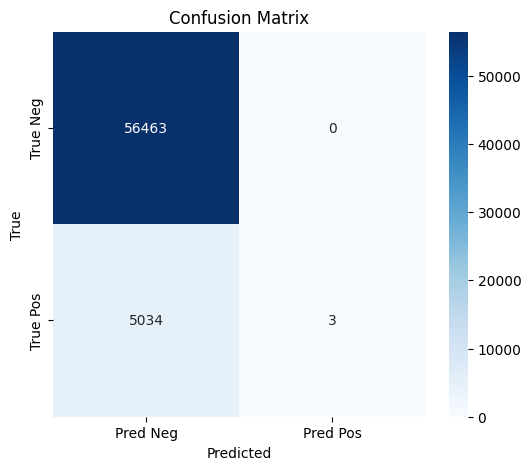

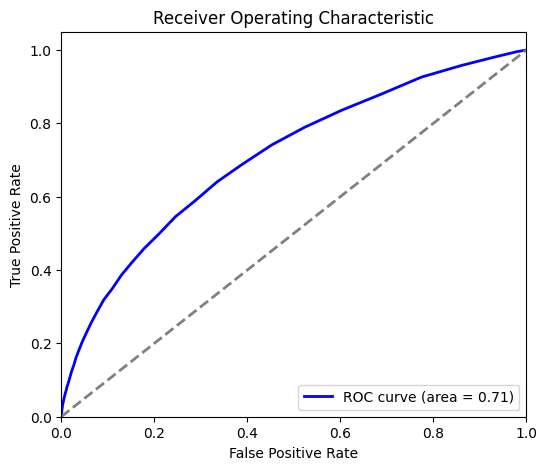

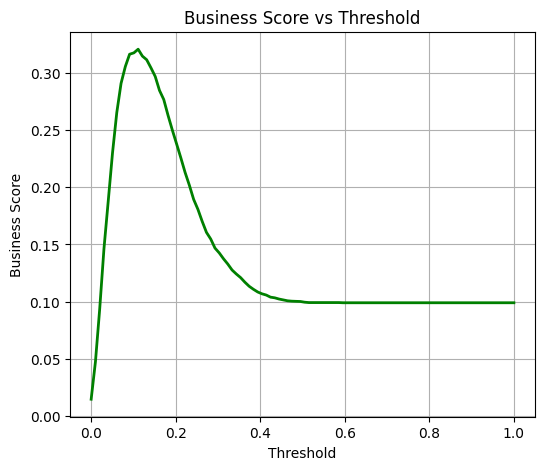

Registered model 'randomforestclassifier_model' already exists. Creating a new version of this model...
Created version '2' of model 'randomforestclassifier_model'.
2025/01/14 13:31:17 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/14 13:31:17 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Méthode d'échantillonnage : SMOTE(random_state=42)


2025/01/14 13:31:20 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/14 13:31:20 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Model parameters: <bound method Pipeline.get_params of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
   

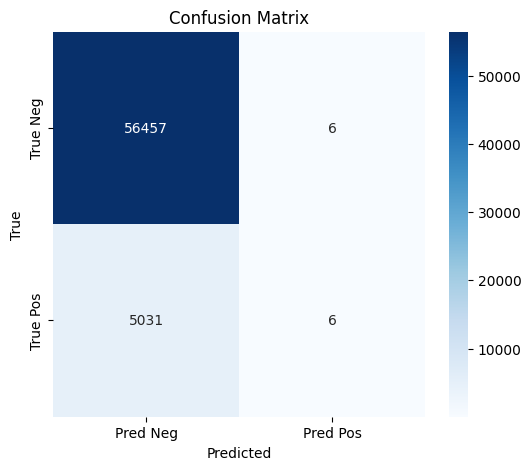

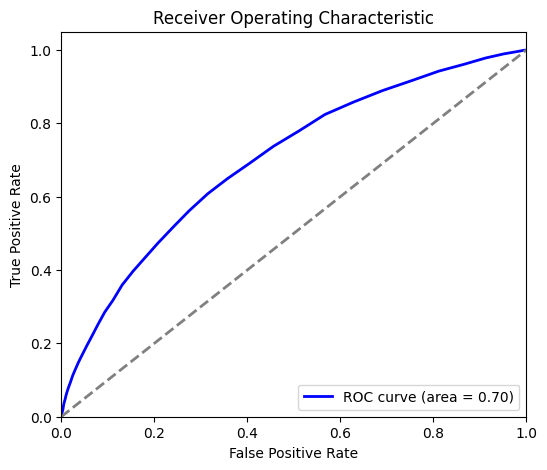

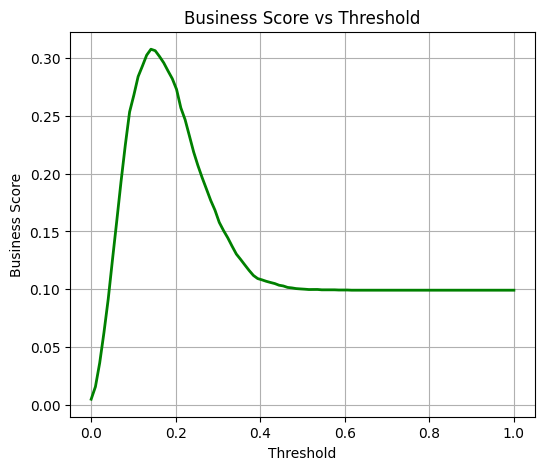

Registered model 'randomforestclassifier_model' already exists. Creating a new version of this model...
Created version '3' of model 'randomforestclassifier_model'.
2025/01/14 13:38:17 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/14 13:38:17 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Méthode d'échantillonnage : RandomUnderSampler(random_state=42)


2025/01/14 13:38:19 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/14 13:38:19 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Model parameters: <bound method Pipeline.get_params of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
   

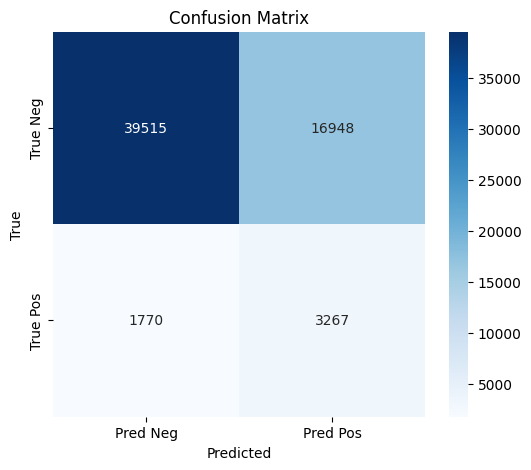

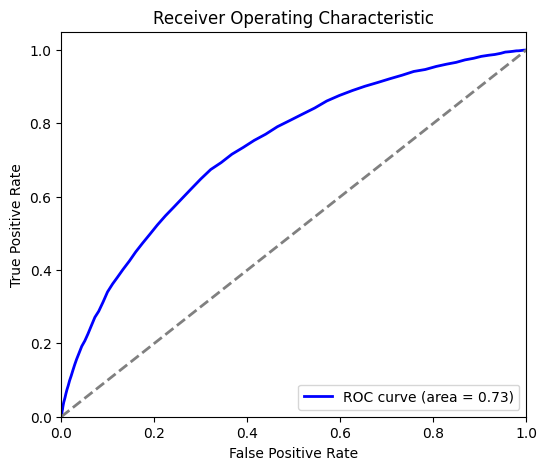

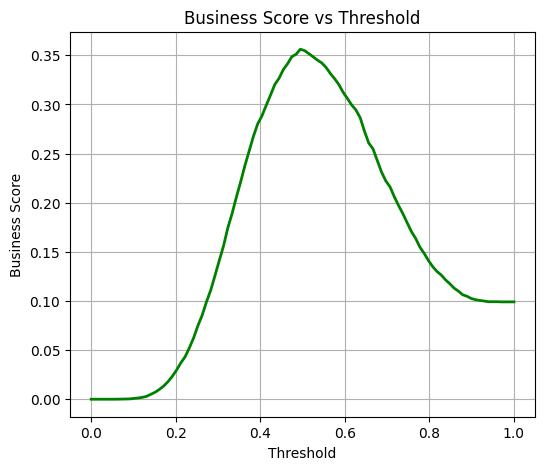

Registered model 'randomforestclassifier_model' already exists. Creating a new version of this model...
Created version '4' of model 'randomforestclassifier_model'.
2025/01/14 13:39:42 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/14 13:39:42 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Méthode d'échantillonnage : RandomOverSampler(random_state=42)


2025/01/14 13:39:45 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/14 13:39:45 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Model parameters: <bound method Pipeline.get_params of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
   

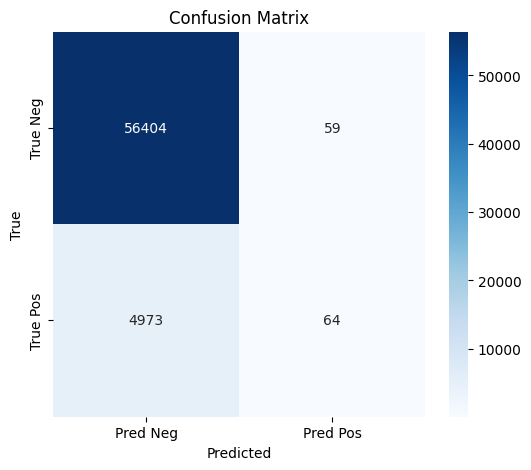

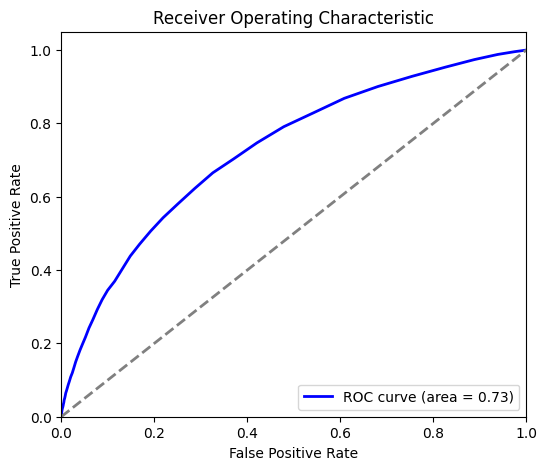

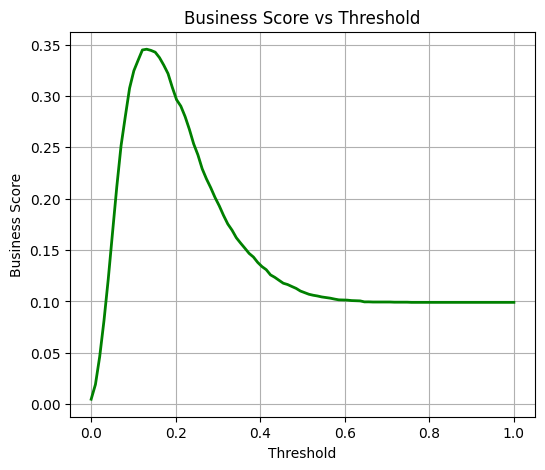

Registered model 'randomforestclassifier_model' already exists. Creating a new version of this model...
Created version '5' of model 'randomforestclassifier_model'.
2025/01/14 13:45:52 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/14 13:45:52 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Méthode d'échantillonnage : ADASYN(random_state=42)


2025/01/14 13:45:56 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/14 13:45:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Model parameters: <bound method Pipeline.get_params of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
   

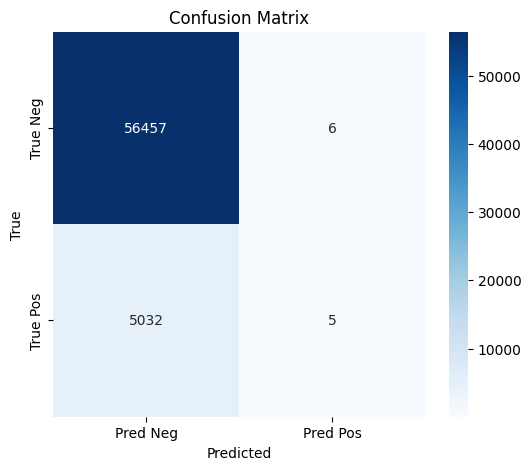

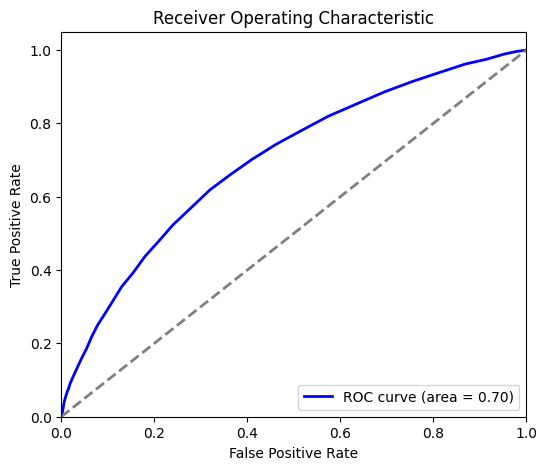

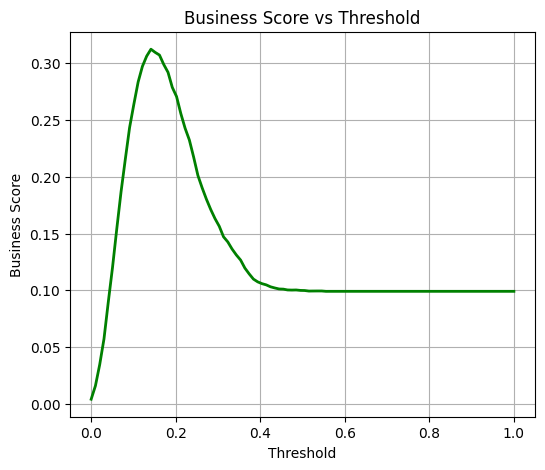

Registered model 'randomforestclassifier_model' already exists. Creating a new version of this model...
Created version '6' of model 'randomforestclassifier_model'.
2025/01/14 13:54:09 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/14 13:54:09 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Méthode d'échantillonnage : BorderlineSMOTE(random_state=42)


2025/01/14 13:54:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/14 13:54:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Model parameters: <bound method Pipeline.get_params of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
   

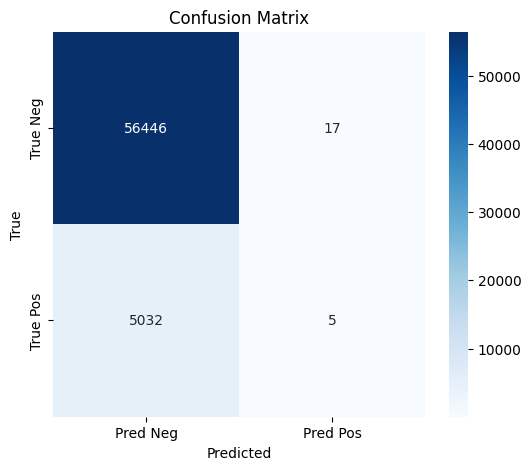

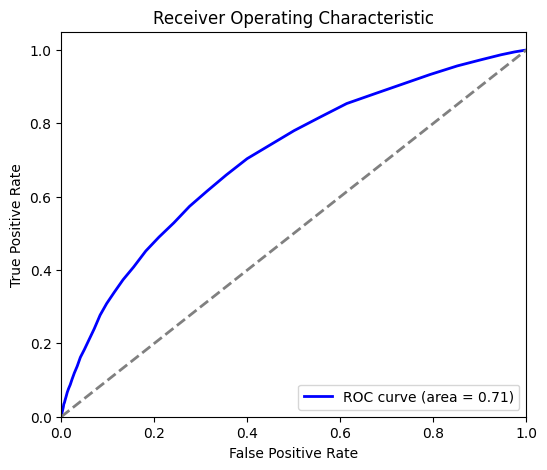

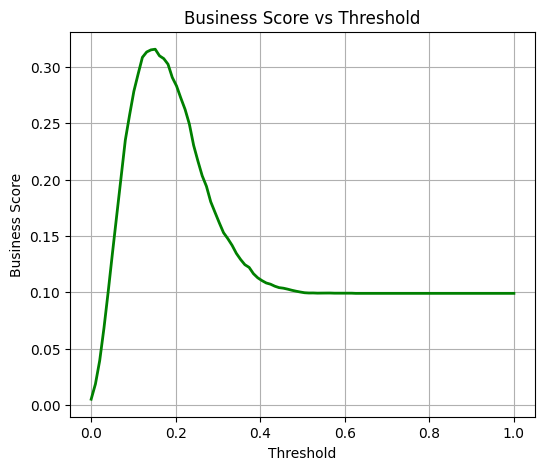

Registered model 'randomforestclassifier_model' already exists. Creating a new version of this model...
Created version '7' of model 'randomforestclassifier_model'.
2025/01/14 14:03:24 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/14 14:03:24 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Méthode d'échantillonnage : SMOTETomek(random_state=42)


2025/01/14 14:03:27 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/14 14:03:27 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Model parameters: <bound method Pipeline.get_params of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
   

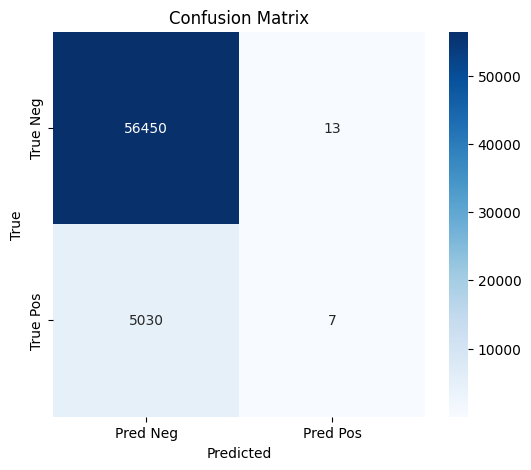

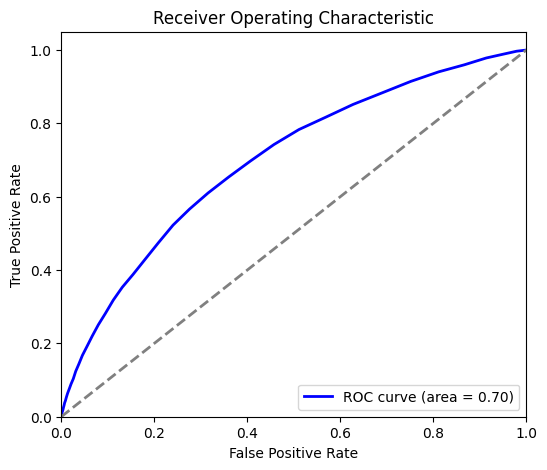

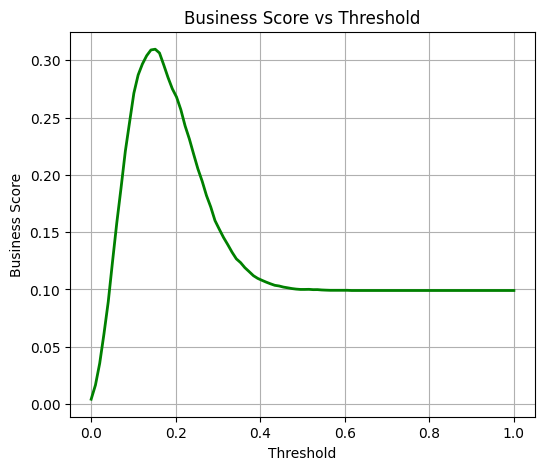

Registered model 'randomforestclassifier_model' already exists. Creating a new version of this model...
Created version '8' of model 'randomforestclassifier_model'.
2025/01/14 14:54:07 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/14 14:54:07 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Méthode d'échantillonnage : SMOTEENN(random_state=42)


2025/01/14 14:54:10 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/14 14:54:10 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Model parameters: <bound method Pipeline.get_params of Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
   

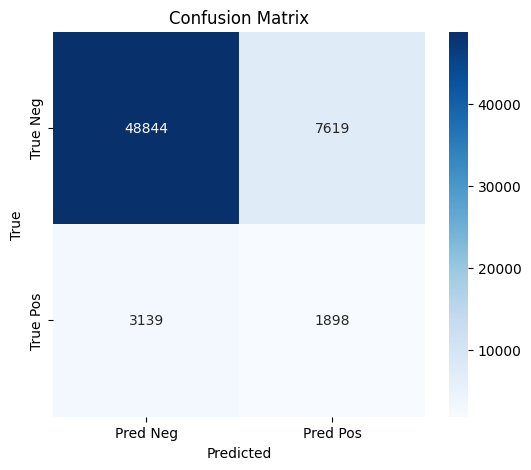

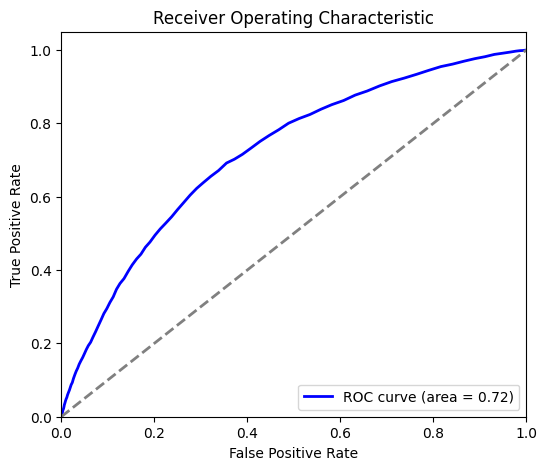

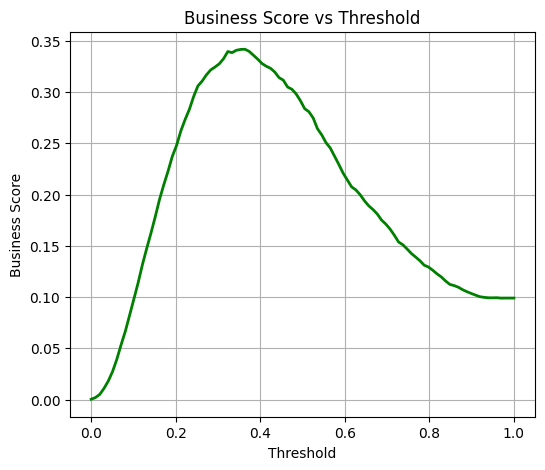

Registered model 'randomforestclassifier_model' already exists. Creating a new version of this model...
Created version '9' of model 'randomforestclassifier_model'.
2025/01/14 15:43:38 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/14 15:43:38 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [ ]:
model = RandomForestClassifier()
sampling_methods = [None,
    SMOTE(random_state=42),
    RandomUnderSampler(random_state=42),
    RandomOverSampler(random_state=42),
    ADASYN(random_state=42),
    BorderlineSMOTE(random_state=42),
    SMOTETomek(random_state=42),
    SMOTEENN(random_state=42)
]
print('Entrainement modéle : ' + str(model))
for methode in sampling_methods:
    print(f"Méthode d'échantillonnage : {methode}")
    pipeline = build_pipeline(
        model=model,
        var_num=var_num,
        var_cat=var_cat,
        sampling_methods=methode
    )
    train_and_log_model(pipeline, train_data, 'RandomForestClassifier')

Ajouter GridSearchCV pour trouver les meilleurs hyperparametres pour RandomForestClassifier

Conclusion :

Trouver les meilleurs hyper-param pour RandomForestClassifier

In [ ]:
pipeline = build_pipeline_gridsearchcv(
    model=RandomForestClassifier(),
    param_grid=param_grids[RandomForestClassifier],
    var_num=var_num,
    var_cat=var_cat,
    custom_scorer=business_scorer,
    sampling_methods=RandomUnderSampler(random_state=42)
)
pipeline

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['CNT_CHILDREN',
                                                                          'AMT_INCOME_TOTAL',
                                                                          'AMT_CREDIT',
                                                                          'AMT_ANNUITY',
                                                                          'AMT_GOODS_PRICE',
                                                                          'REGION_POPULATION_RELATIVE',
                                                                          'DAYS_BIRTH',
                                                                          'DAYS_EMPLOYED',
                                                                          'DAYS_REGISTRATIO...
                                        RandomUnderSampler(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [None, 10, 20,
                                                               50],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [100, 200,
                                                                  500]},
             scoring=<function business_scorer at 0x7d3e6a4d40d0>)

2025/01/14 10:27:31 INFO mlflow.tracking.fluent: Experiment with name 'Gridsearchcv' does not exist. Creating a new experiment.
2025/01/14 10:27:36 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/14 10:27:36 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Best model parameters: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
Fit_time 10006.372770309448
AUC 0.7307002319878398
F1_score 0.2583911344973292
Recall 0.6434385546952551
optimal_threshold 0.07070707070707072


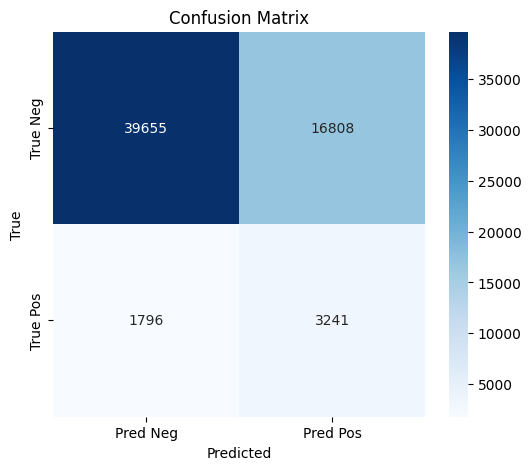

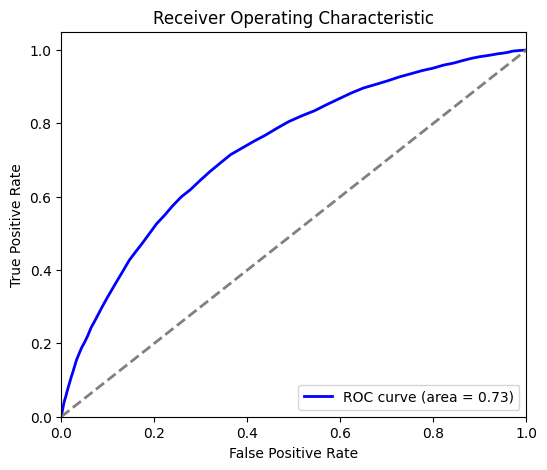

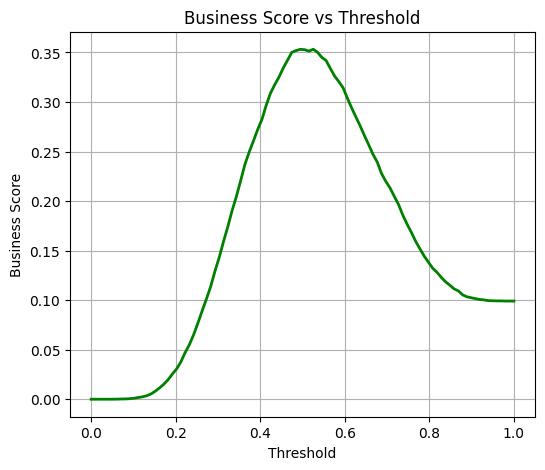

Successfully registered model 'randomforestclassifier_model'.
Created version '1' of model 'randomforestclassifier_model'.
2025/01/14 13:14:35 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/14 13:14:36 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [ ]:
train_and_log_model(pipeline, train_data, 'Gridsearchcv')

Relancer la machine pour tester d'autre classifier

In [ ]:
# prompt: arrêter l'excution automatique du notebook à se stade et passer à une excution manuelle

# Add this line to stop automatic execution and allow manual execution
# You can execute cells manually afterwards.
assert False

### Entrainement SVC

In [ ]:
pipeline = build_pipeline_gridsearchcv(
    model=SVC(),
    param_grid=param_grids[SVC],
    var_num=var_num,
    var_cat=var_cat,
    custom_scorer=business_scorer,
    sampling_methods=SVMSMOTE()
)
pipeline
train_and_log_model(pipeline, train_data, 'SVC')

2025/01/14 22:35:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/14 22:35:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


In [ ]:
pipeline = build_pipeline_gridsearchcv(
    model=SVC(),
    param_grid=param_grids[SVC],
    var_num=var_num,
    var_cat=var_cat,
    custom_scorer=business_scorer,
    sampling_methods=RandomUnderSampler(random_state=42)
)
pipeline
run_and_log_model(pipeline, train_data, 'SVC')

In [ ]:
classifiers = [
    LGBMClassifier,
    RandomForestClassifier,
    XGBClassifier,
    KNeighborsClassifier,
    GaussianProcessClassifier,
    DecisionTreeClassifier,
    AdaBoostClassifier,
    GaussianNB,
    QuadraticDiscriminantAnalysis,
    GradientBoostingClassifier,
]

In [ ]:
for classifier in classifiers:
    print(f"Classifier : {classifier}")
    sampling_methods = [None,
        SMOTE(random_state=42),
        RandomUnderSampler(random_state=42),
        RandomOverSampler(random_state=42),
        ADASYN(random_state=42),
        BorderlineSMOTE(random_state=42),
        SVMSMOTE(random_state=42),
        KMeansSMOTE(random_state=42),
    ]
    for methode in sampling_methods:
        print(f"Méthode d'échantillonnage : {methode}")
        pipeline = build_pipeline_gridsearchcv(
            model=classifier,
            param_grid=param_grids[classifier],
            var_num=var_num,
            var_cat=var_cat,
            custom_scorer=business_scorer,
            sampling_methods=methode
        )
        train_and_log_model(pipeline, train_data, 'Sampling_methods')

In [ ]:
train_and_log_model(pipeline, train_data, 'Default')

In [ ]:
X = train_data.drop('TARGET', axis=1)
y = train_data['TARGET']

# Split into train and test sets (60% train, 40% remaining for validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Further split the remaining data into test and validation sets (50% test, 50% validation)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
shap.initjs()

In [ ]:

if isinstance(pipeline, GridSearchCV):
    # Extract the model inside the pipeline from GridSearchCV
    model = pipeline.estimator.named_steps['model']
else:
    # Directly extract the model name from the pipeline
    model = pipeline[-1]
# Explainability with SHAP
explainer = shap.TreeExplainer(pipeline.named_steps['model'])
shap_values = explainer.shap_values(pipeline[:-1].transform(X_val))

# Log SHAP values and other artifacts
mlflow.shap.log_explanation(
    shap_values,
    X_val,
    pipeline[:-1].transform(X_val), # Use transformed data for SHAP
    feature_names=feature_names
)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values.values[1, :], X_val.iloc[0, :])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values.values[:1000, :], X_val.iloc[:1000, :])

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
for name in X_val.columns:
    shap.dependence_plot(name, shap_values.values, X, display_features=X_val)

In [ ]:
train_data = create_new_features(train_data)

In [ ]:
train_and_log_model(pipeline, train_data, 'Default')

In [ ]:

#Creation d'un dossier sur le drive pour sauvegarder les expériences

%cd /content/drive/MyDrive
!mkdir experiments

%cd /content
!cp -r mlruns artifacts /content/drive/MyDrive/experiments

/content/drive/MyDrive
mkdir: cannot create directory ‘experiments’: File exists
/content


In [ ]:
from pyngrok import ngrok
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2p5OGmrVYYlS1CZkhcuFk4YjSSx_51YtMMeKwW17qWk9uNAbN"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://47ce-34-86-4-232.ngrok-free.app


In [ ]:
!mlflow ui

[2025-01-14 16:11:08 +0000] [84567] [INFO] Starting gunicorn 23.0.0
[2025-01-14 16:11:08 +0000] [84567] [INFO] Listening at: http://127.0.0.1:5000 (84567)
[2025-01-14 16:11:08 +0000] [84567] [INFO] Using worker: sync
[2025-01-14 16:11:08 +0000] [84568] [INFO] Booting worker with pid: 84568
[2025-01-14 16:11:09 +0000] [84569] [INFO] Booting worker with pid: 84569
[2025-01-14 16:11:09 +0000] [84574] [INFO] Booting worker with pid: 84574
[2025-01-14 16:11:09 +0000] [84575] [INFO] Booting worker with pid: 84575
[2025-01-14 16:12:04 +0000] [84567] [INFO] Handling signal: int
[2025-01-14 16:12:04 +0000] [84569] [INFO] Worker exiting (pid: 84569)
[2025-01-14 16:12:04 +0000] [84575] [INFO] Worker exiting (pid: 84575)
[2025-01-14 16:12:04 +0000] [84568] [INFO] Worker exiting (pid: 84568)
[2025-01-14 16:12:04 +0000] [84574] [INFO] Worker exiting (pid: 84574)

Aborted!
[2025-01-14 16:12:06 +0000] [84567] [INFO] Shutting down: Master
